In [1]:
import cv2
import numpy as np
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# --- Parameters ---
TRAIN_DIR = '/home/tanuj/DIP_project/dataset/train'  # Training data directory
TEST_DIR = '/home/tanuj/DIP_project/dataset/test'  # Testing data directory
LABELS = {'NORMAL': 0, 'PNEUMONIA': 1}

In [3]:
# --- Image Processing ---
def apply_histogram_equalization(img):
    return cv2.equalizeHist(img)

def compute_fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return fshift

def compute_magnitude_spectrum(fshift):
    return 20 * np.log(np.abs(fshift) + 1e-8)

def compute_features(magnitude_spectrum):
    mag_spec = magnitude_spectrum / np.sum(magnitude_spectrum)
    energy = np.sum(mag_spec ** 2)
    mag_spec_safe = np.clip(mag_spec, 1e-8, None)
    entropy = -np.sum(mag_spec_safe * np.log2(mag_spec_safe))
    mean_coeff = np.mean(mag_spec)
    std_coeff = np.std(mag_spec)
    return [energy, entropy, mean_coeff, std_coeff]

In [4]:

# --- Feature Extraction Wrapper ---
def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img_eq = apply_histogram_equalization(img)
    fshift = compute_fft(img_eq)
    magnitude_spectrum = compute_magnitude_spectrum(fshift)
    features = compute_features(magnitude_spectrum)

    return features


In [5]:
# --- Feature Extraction + Visualization (First Image Only) ---
first_visualized = {'NORMAL': False, 'PNEUMONIA': False}
def extract_features(image_path, label):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img_eq = apply_histogram_equalization(img)
    fshift = compute_fft(img_eq)
    magnitude_spectrum = compute_magnitude_spectrum(fshift)
    features = compute_features(magnitude_spectrum)

    if not first_visualized[label]:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{label} - Original')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img_eq, cmap='gray')
        plt.title(f'{label} - Histogram Equalized')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title(f'{label} - Magnitude Spectrum')
        plt.axis('off')

        plt.tight_layout()
        plt.show()
        first_visualized[label] = True

    return features

Processing NORMAL in /home/tanuj/DIP_project/dataset/train:   0%|          | 0/1342 [00:00<?, ?it/s]

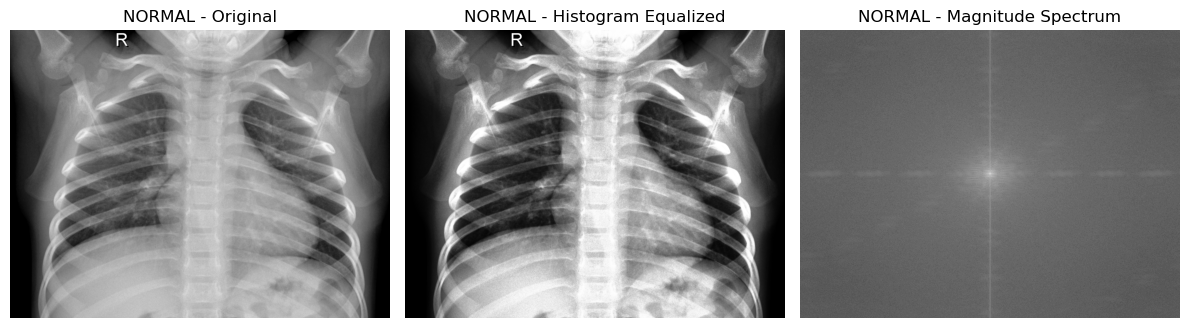

Processing NORMAL in /home/tanuj/DIP_project/dataset/train: 100%|██████████| 1342/1342 [04:39<00:00,  4.80it/s]
Processing PNEUMONIA in /home/tanuj/DIP_project/dataset/train:   0%|          | 0/3876 [00:00<?, ?it/s]

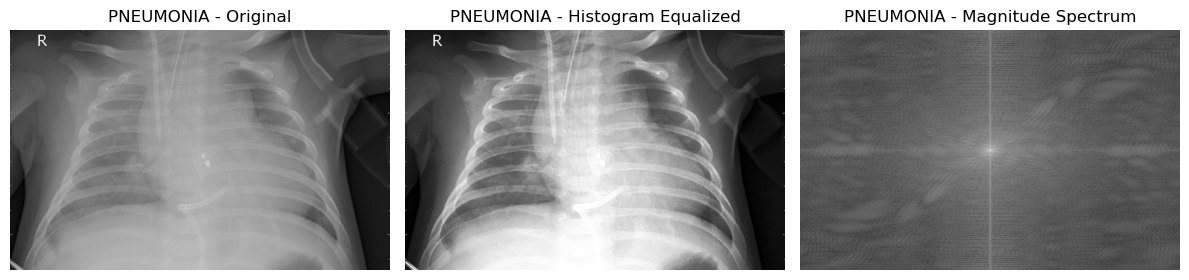

Processing PNEUMONIA in /home/tanuj/DIP_project/dataset/train: 100%|██████████| 3876/3876 [04:24<00:00, 14.65it/s]
Processing NORMAL in /home/tanuj/DIP_project/dataset/test: 100%|██████████| 234/234 [00:49<00:00,  4.70it/s]
Processing PNEUMONIA in /home/tanuj/DIP_project/dataset/test: 100%|██████████| 390/390 [00:21<00:00, 18.40it/s]


In [6]:
# --- Load Dataset ---
def load_data(directory):
    X, y, filenames = [], [], []
    for label in LABELS:
        folder = os.path.join(directory, label)
        for file in tqdm(os.listdir(folder), desc=f"Processing {label} in {directory}"):
            path = os.path.join(folder, file)
            features = extract_features(path, label)
            if features:
                X.append(features)
                y.append(LABELS[label])
                filenames.append(file)
    return np.array(X), np.array(y), filenames

X_train, y_train, files_train = load_data(TRAIN_DIR)
X_test, y_test, files_test = load_data(TEST_DIR)

In [7]:
# --- Save CSVs ---
pd.DataFrame(X_train, columns=["Energy", "Entropy", "Mean_Coeff", "Std_Coeff"]).assign(Label=y_train, File=files_train).to_csv("xray_features_train.csv", index=False)
pd.DataFrame(X_test, columns=["Energy", "Entropy", "Mean_Coeff", "Std_Coeff"]).assign(Label=y_test, File=files_test).to_csv("xray_features_test.csv", index=False)

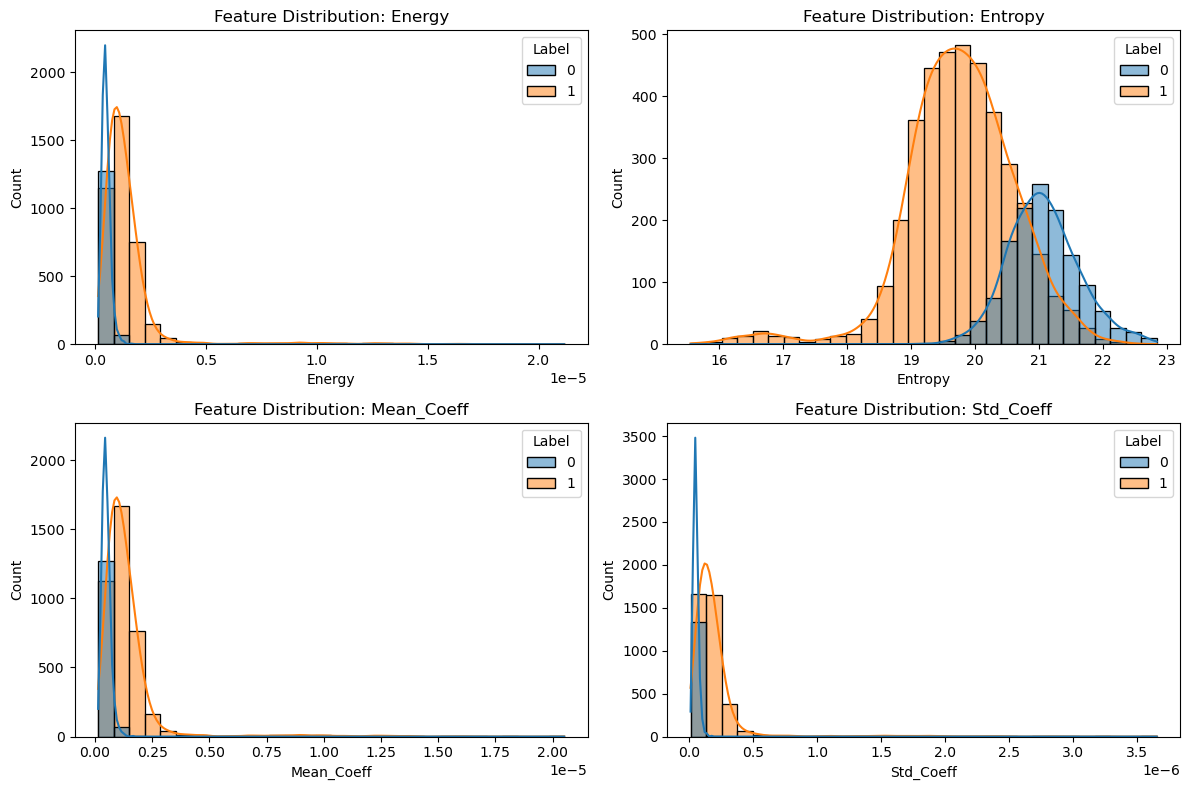

In [8]:
# --- Feature Distribution Visualization ---
df_train = pd.read_csv("xray_features_train.csv")
plt.figure(figsize=(12, 8))
for i, col in enumerate(["Energy", "Entropy", "Mean_Coeff", "Std_Coeff"]):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=df_train, x=col, hue="Label", bins=30, kde=True)
    plt.title(f"Feature Distribution: {col}")
plt.tight_layout()
plt.show()

In [10]:
# --- Train Models ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

accuracies = {}
conf_matrices = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))
    print(f"{name} Accuracy:", acc)

    accuracies[name] = acc
    conf_matrices[name] = cm



Training SVM...

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.58      0.71       234
           1       0.79      0.96      0.87       390

    accuracy                           0.82       624
   macro avg       0.85      0.77      0.79       624
weighted avg       0.83      0.82      0.81       624

SVM Accuracy: 0.8189102564102564

Training Random Forest...

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.13      0.22       234
           1       0.65      0.95      0.77       390

    accuracy                           0.65       624
   macro avg       0.64      0.54      0.50       624
weighted avg       0.64      0.65      0.56       624

Random Forest Accuracy: 0.6458333333333334

Training Gradient Boosting...

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.70      

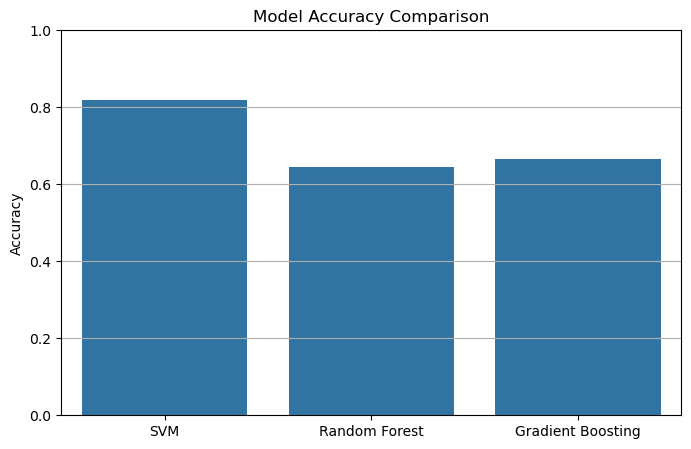

In [11]:
# --- Accuracy Bar Chart ---
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.grid(axis='y')
plt.show()

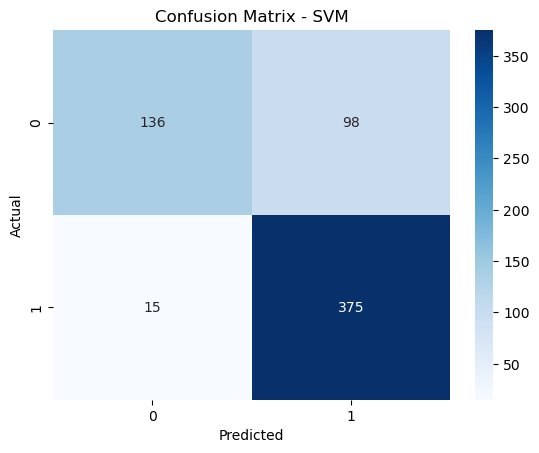

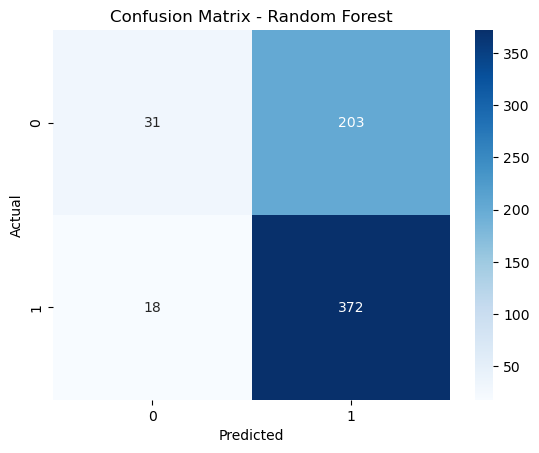

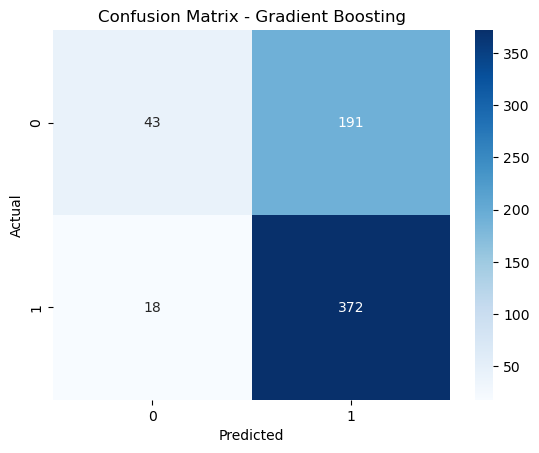

In [12]:
# --- Confusion Matrices ---
for name, cm in conf_matrices.items():
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()